# Heriarchical Clustering

The results of applying K-means or K-medoids clustering algorithms depend on the choice for the number of clusters to be searched and a starting configuration assignment. In contrast, hierarchical clustering methods do not require such specifications. Instead, they require the user to specify a measure of dissimilarity between (disjoint) groups of observations, based on the pairwise dissimilarities among the observations in the two groups. As the name suggests, they produce hierarchical representations in which the clusters at each level of the hierarchy are created by merging clusters at the next lower level. At the lowest level, each cluster contains a single observation. At the highest level there is only one cluster containing all of the data.

Strategies for hierarchical clustering come in two flavors: **agglomerative (bottom-up)** and **divisive (top-down)**.

Before going forward, let us load some important libraries and modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_circles

## Divisive Paradigm

Divisive clustering algorithms begin with the entire data set as a single cluster, and recursively divide one of the existing clusters into two child clusters at each iteration in a top-down fashion. This approach has not been studied nearly as extensively as agglomerative methods in the clustering literature. It has been explored somewhat in the engineering literature in the context of compression. In the clustering setting, a potential advantage of divisive over agglomerative methods can occur when interest is focused on partitioning the data into a relatively small number of clusters.

The divisive paradigm can be employed by recursively applying any of the combinatorial methods, such as K-means or K-medoids with $K=2$, to perform the splits at each iteration. However, such an approach would depend on the starting configuration specified at each step. In addition, it would not necessarily produce a splitting sequence that possesses the monotonicity property required for a dendrogram representation.

A divisive algorithm that avoids these problems was proposed by Mac-naughton Smith et al. in 1965. Let $X=\{x_1,x_2,\dots,x_n\}$, where $x_i\in\mathbb{R}^p$, $i=1,2,\dots,n$. Let $d:\mathbb{R}^p\times S\to[0,\infty)$ be an average dissimilarity measure, where $S$ is some set. Their proposed algorithm is the following:

- All observations are in a single cluster $G$.
- Then, the observation whose average dissimilarity from all the other observations is largest becomes the first member of a second cluster $H_1$. Let this observation be $x'$, and let $H_2=G-{x'}$. 
- Compute $f(x)=d(x,H_1)-d(x,H_2)$.
- Let $x''\in H_2$ be the element that maximizes $f(x)$. Then, the new partition is $H_1=H_1\cup{x''}$ and $H_2=H_2-{x''}$.
- This process continues until $f(x)$ is negative, that is, there are no longer any observations in $H_2$ that are, on average, closer to those in $H_1$. The result is a split of the original cluster $G$ into two child clusters $H_1$ and $H_2$.
- The recursive splitting continues until all clusters either become singletons or all members of each one have zero dissimilarity from one another.

To ilustrate how the divisive approach works, let us create some data.

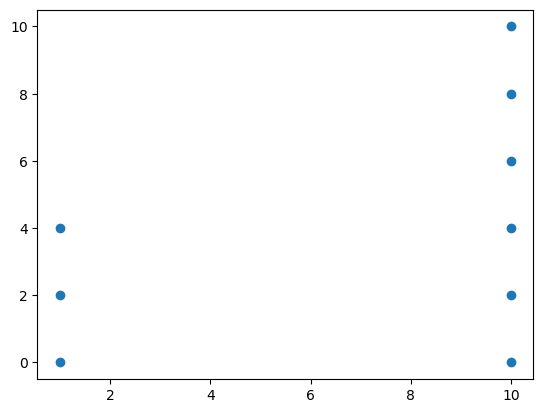

In [2]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0], [10, 6], [10, 8], [10, 10]])
plt.scatter(X[:,0], X[:,1])
plt.show()

An implementation of the divisive paradigm using K-means is the `BisectingKMeans` object from the `sklearn` library. Let us run it with the parameter `n_clusters` equal to three.

In [3]:
bisect_means = BisectingKMeans(n_clusters=9, random_state=0).fit(X)

Now we take a peek into the clusters that this method obtained.

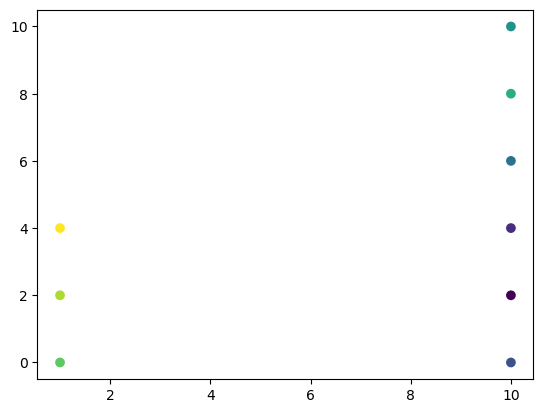

In [4]:
plt.scatter(X[:,0], X[:,1], c=bisect_means.labels_)
plt.show()

And there you have it, the divisive paradigm. By the way, this example was taken from [4].

## Agglomerative Paradigm

Agglomerative clustering algorithms begin with every observation representing a singleton cluster. At each of the $n1$ steps the closest two, or least dissimilar, clusters are merged into a single cluster, producing one less cluster at the next higher level. Therefore, a measure of dissimilarity between two clusters must be defined.

Let $G$ and $H$ represent two such groups. The dissimilarity $d(G,H)$ between $G$ and $H$ is computed from the set of pairwise observation dissimilarities $d_{ij}$, where one member of the pair $i$ is in $G$ and the other $j$ is in $H$.

**Single linkage (SL)** agglomerative clustering takes the intergroup dissimilarity to be that of the closest (least dissimilar) pair:

$$d_{SL}(G,H)=\min_{i\in G,j\in H}d_{ij}.$$

**Complete linkage (CL)** agglomerative clustering, also known as furthest-neighbor technique, takes the intergroup dissimilarity to be that of the furthest, or most dissimilar, pair:

$$d_{CL}(G,H)=\max_{i\in G,j\in H}d_{ij}.$$

**Group average (GA)** clustering uses the average dissimilarity between the groups, say, $G$ and $H$:

$$d_{GA}(G,H)=\frac{1}{n_Gn_H}\sum_{i=1}^{n_G}\sum_{j=1}^{n_H}d_{ij},$$

where $N_G$ and $N_H$ are the number of observations in $G$ and $H$, respectively.

Let us see agglomerative clustering in action. First, we will create some synthetic data.

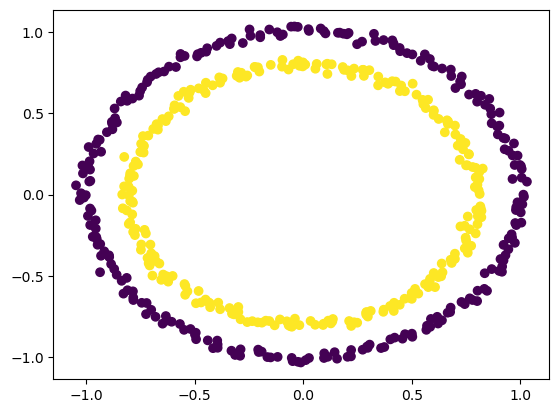

In [5]:
X, y = make_circles(n_samples=500, noise = 0.02, random_state = 2) 
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

The `AgglomerativeClustering` object performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

- **Ward:** It minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

- **Maximum or complete linkage:** It minimizes the maximum distance between observations of pairs of clusters.

- **Average linkage:** It minimizes the average of the distances between all observations of pairs of clusters.

- **Single linkage:** It minimizes the distance between the closest observations of pairs of clusters.

Let us try these options with our synthetic data.

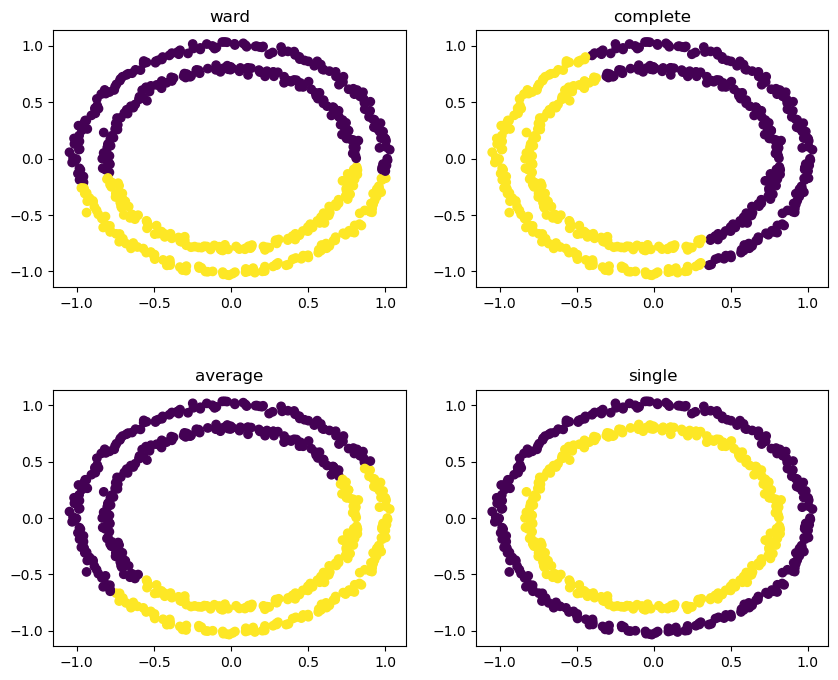

In [6]:
links = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
n = 4

for n, link in enumerate(links):
    clustering = AgglomerativeClustering(linkage=link).fit(X)
    i, j = divmod(n, 2)
    axes[i, j].scatter(X[:,0], X[:,1], c=clustering.labels_)
    axes[i, j].set_title(link)

plt.show()

As you can see, **single linkage** is pretty good at capturing those two circles, something that `Kmeans` can not accomplish. By the way, the number of clusters that are found is two by default; if you want a different number of clusters set the `n_clusters` parameter to a different value. 

### Dendrogram

Recursive binary splitting/agglomeration can be represented by a rooted binary tree. The nodes of the trees represent groups. The root node represents the entire data set. The $n$ terminal nodes each represent one of the individual observations. Each nonterminal node, or parent, has two child nodes. For divisive clustering, the two childs represent the two groups resulting from the split of the parent; for agglomerative clustering, the childs represent the two groups that were merged to form the parent.

Most agglomerative and some divisive methods, when viewed bottom-up, possess a monotonicity property. That is, the dissimilarity between merged clusters is monotone increasing with the level of the merger. Thus the binary tree can be plotted so that the height of each node is proportional to the value of the intergroup dissimilarity between its two childs. The terminal nodes representing individual observations are all plotted at zero height. This type of graphical display is called a **dendrogram**.

A dendrogram provides a highly interpretable complete description of the hierarchical clustering in a graphical format. This is one of the main reasons for the popularity of hierarchical clustering methods. This said, ley us see the different dendrograms that we obtain for different types of linkage with the synthetic data that we have been working with.

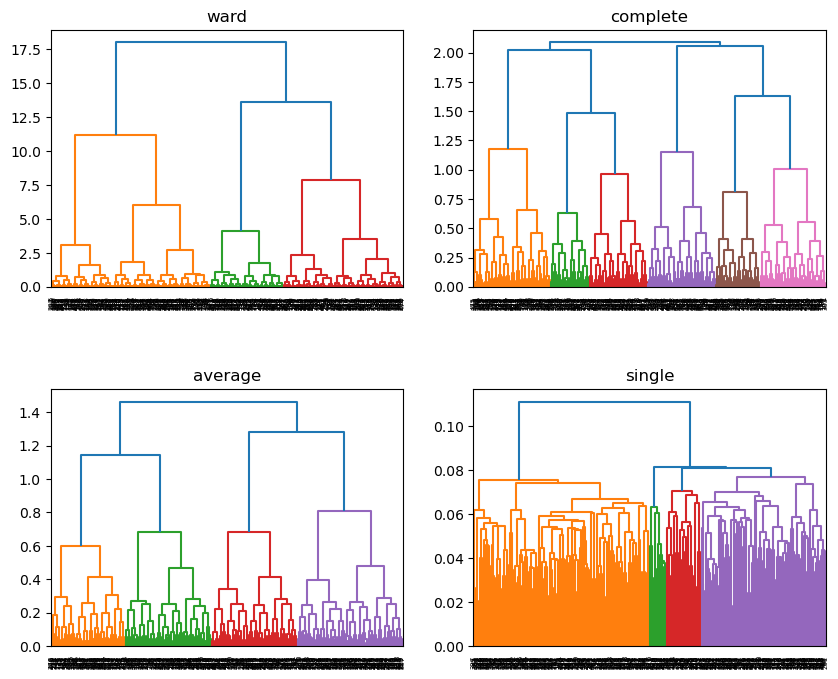

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
n = 4

for n, link in enumerate(links):
    i, j = divmod(n, 2)
    shc.dendrogram(shc.linkage(X, method=link), ax=axes[i, j])
    axes[i, j].set_title(link)

plt.show()

## References

[1] *Hastie, T., Tibshirani, R., Friedman, J. H., "The elements of statistical learning: data mining, inference, and prediction," New York, Springer, 2009.*

[2] *Roux, Maurice. "A comparative study of divisive hierarchical clustering algorithms," arXiv preprint arXiv:1506.08977 (2015).*

[3] https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

[4] https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans

[5] https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram
